Epoch 1/50 - G Loss: 0.7504, D Loss: 1.3686
Epoch 2/50 - G Loss: 0.7043, D Loss: 1.3753
Epoch 3/50 - G Loss: 0.6994, D Loss: 1.3948
Epoch 4/50 - G Loss: 0.7051, D Loss: 1.3753
Epoch 5/50 - G Loss: 0.7325, D Loss: 1.3740
Epoch 6/50 - G Loss: 0.7582, D Loss: 1.3587
Epoch 7/50 - G Loss: 0.7079, D Loss: 1.4145
Epoch 8/50 - G Loss: 0.7132, D Loss: 1.3572
Epoch 9/50 - G Loss: 0.7536, D Loss: 1.2868
Epoch 10/50 - G Loss: 0.7526, D Loss: 1.3965
Epoch 11/50 - G Loss: 0.7230, D Loss: 1.3668
Epoch 12/50 - G Loss: 0.7219, D Loss: 1.3258
Epoch 13/50 - G Loss: 0.7718, D Loss: 1.3123
Epoch 14/50 - G Loss: 0.7682, D Loss: 1.4155
Epoch 15/50 - G Loss: 0.7000, D Loss: 1.3925
Epoch 16/50 - G Loss: 0.7216, D Loss: 1.3458
Epoch 17/50 - G Loss: 0.7296, D Loss: 1.3801
Epoch 18/50 - G Loss: 0.6897, D Loss: 1.3945
Epoch 19/50 - G Loss: 0.7608, D Loss: 1.3187
Epoch 20/50 - G Loss: 0.7555, D Loss: 1.3524
Epoch 21/50 - G Loss: 0.7768, D Loss: 1.3990
Epoch 22/50 - G Loss: 0.7325, D Loss: 1.3431
Epoch 23/50 - G Los

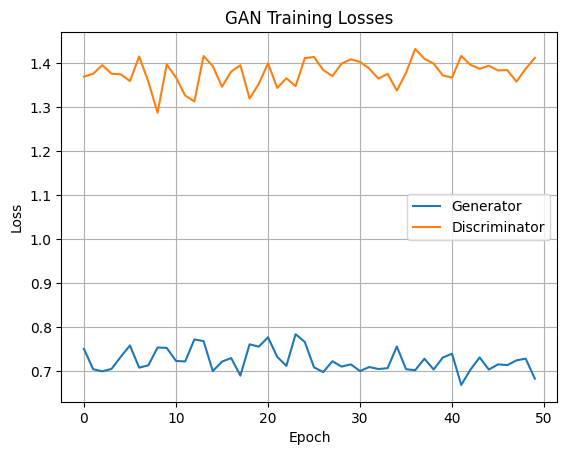


📊 Evaluation Results
True Positives: 342
False Positives: 2158
True Negatives: 41563
False Negatives: 5937
Precision: 0.1368
Recall: 0.0545
F1 Score: 0.0779


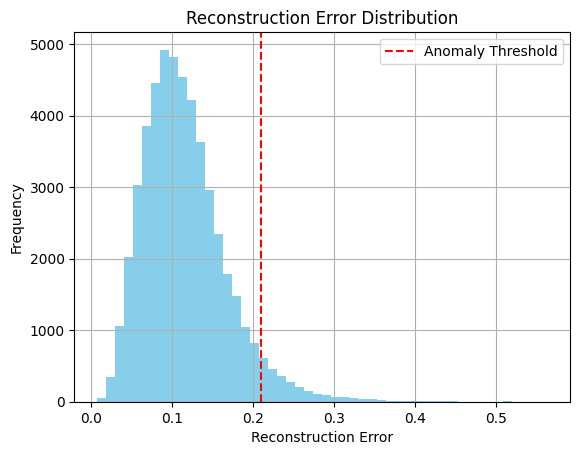


🔍 Top Contributing Features to Anomaly:
Current (A): Diff = 1.2295
Temperature (°C): Diff = 1.1477
Predicted Load (kW): Diff = 1.1207
Power Consumption (kW): Diff = 1.1206
Reactive Power (kVAR): Diff = 0.9713


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

# Load and prepare dataset
df = pd.read_csv("/content/smart_grid_dataset.csv")
labels = df[["Overload Condition", "Transformer Fault"]]
features = df.drop(columns=["Timestamp", "Overload Condition", "Transformer Fault"])
feature_names = features.columns.tolist()

# Normalize
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Filter only normal data
normal_mask = (labels["Overload Condition"] == 0) & (labels["Transformer Fault"] == 0)
normal_data = features_scaled[normal_mask.values]

# Convert to Tensor
tensor_data = torch.tensor(normal_data, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(tensor_data), batch_size=128, shuffle=True)

# Define GAN models
class Generator(nn.Module):
    def __init__(self, input_dim=32, output_dim=13):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim=13):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128), nn.LeakyReLU(0.2),
            nn.Linear(128, 64), nn.LeakyReLU(0.2),
            nn.Linear(64, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
criterion = nn.BCELoss()
noise_dim = 32
epochs = 50
g_losses, d_losses = [], []

# Training loop
for epoch in range(epochs):
    g_loss_epoch, d_loss_epoch = 0, 0
    for real_batch, in train_loader:
        real_batch = real_batch.to(device)
        batch_size = real_batch.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train D
        d_optimizer.zero_grad()
        real_output = D(real_batch)
        d_loss_real = criterion(real_output, real_labels)

        z = torch.randn(batch_size, noise_dim).to(device)
        fake_data = G(z)
        fake_output = D(fake_data.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train G
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_data = G(z)
        output = D(fake_data)
        g_loss = criterion(output, real_labels)
        g_loss.backward()
        g_optimizer.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

    g_losses.append(g_loss_epoch / len(train_loader))
    d_losses.append(d_loss_epoch / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs} - G Loss: {g_losses[-1]:.4f}, D Loss: {d_losses[-1]:.4f}")

# Plot training losses
plt.plot(g_losses, label="Generator")
plt.plot(d_losses, label="Discriminator")
plt.legend()
plt.title("GAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Anomaly Detection
def reconstruction_error(real_data, generator, noise_dim=32):
    generator.eval()
    with torch.no_grad():
        real_tensor = torch.tensor(real_data, dtype=torch.float32).to(device)
        recon = []
        for _ in range(5):
            z = torch.randn(real_tensor.size(0), noise_dim).to(device)
            gen_samples = generator(z)
            recon.append(gen_samples)
        recon_mean = torch.stack(recon).mean(dim=0)
        errors = torch.mean((real_tensor - recon_mean) ** 2, dim=1)
        return errors.cpu().numpy(), recon_mean.cpu().numpy()

errors, recon_data = reconstruction_error(features_scaled, G)
threshold = np.percentile(errors, 95)
recon_anomalies = errors > threshold

# Evaluation
true_anomalies = (labels["Overload Condition"] == 1) | (labels["Transformer Fault"] == 1)
TP = np.sum(recon_anomalies & true_anomalies.values)
FP = np.sum(recon_anomalies & ~true_anomalies.values)
TN = np.sum(~recon_anomalies & ~true_anomalies.values)
FN = np.sum(~recon_anomalies & true_anomalies.values)

precision = TP / (TP + FP + 1e-9)
recall = TP / (TP + FN + 1e-9)
f1 = 2 * precision * recall / (precision + recall + 1e-9)

print("\n📊 Evaluation Results")
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")
print(f"False Negatives: {FN}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Histogram of errors
plt.hist(errors, bins=50, color="skyblue")
plt.axvline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Feature contribution for top anomaly
top_idx = np.argmax(errors)
feature_diffs = np.abs(features_scaled[top_idx] - recon_data[top_idx])
top_features = np.argsort(feature_diffs)[::-1]

print("\n🔍 Top Contributing Features to Anomaly:")
for idx in top_features[:5]:
    print(f"{feature_names[idx]}: Diff = {feature_diffs[idx]:.4f}")


In [ ]:
def detect_anomalies(data, model, threshold=0.5):
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    scores = model(data_tensor).cpu().detach().numpy().flatten()
    return scores < threshold  # True = anomaly

# Apply to full dataset (normalized)
full_scaled = scaler.transform(features)
anomalies = detect_anomalies(full_scaled, D)
print("Anomalies detected:", np.sum(anomalies))

Anomalies detected: 9394
